In [2]:
import torch
import random
from PIL import Image
import os
from torchvision.datasets import CIFAR10, CIFAR100, CocoCaptions, ImageNet
import slip_models
from tokenizer import SimpleTokenizer

import torchvision.transforms as T
from torchvision import datasets, transforms


from tqdm import tqdm
import json
import matplotlib.pyplot as plt

import numpy as np
%pip install ipywidgets
%pip install update tqdm%matplotlib inline


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: Invalid requirement: 'tqdm%matplotlib'
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# !/export/home/google-cloud-sdk/bin/gsutil -m cp gs://sfr-tpu-us-east1-research/bwallace/ckpts/models/multimodel_clip/parallel_vision_standard_text/viz_parallel_text_standard_head_dim_64_per_expert_norm_bs_1024_epoch_30.ckpt ckpts/viz_parallel_text_standard_head_dim_64_per_expert_norm_bs_1024_epoch_30.ckpt
!/export/home/google-cloud-sdk/bin/gsutil -m cp gs://sfr-tpu-us-east1-research/bwallace/ckpts/models/multimodel_clip/parallel_vision_standard_text/viz_parallel_text_standard_head_dim_64_top1_expert_loss_no_entroy_bs_1024_epoch_6.ckpt ckpts/viz_parallel_text_standard_head_dim_64_top1_expert_loss_no_entroy_bs_1024_epoch_6.ckpt


Copying gs://sfr-tpu-us-east1-research/bwallace/ckpts/models/multimodel_clip/parallel_vision_standard_text/viz_parallel_text_standard_head_dim_64_top1_expert_loss_no_entroy_bs_1024_epoch_6.ckpt...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1/1 files][  1.5 GiB/  1.5 GiB] 100% Done                                    
Operation completed over 1 objects/1.5 GiB.                                      


In [4]:
preprocess = T.Compose(
                    [
                        T.Resize(256),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]
                        )

grayscale_preprocess = T.Compose(
                    [
                        T.Resize(256),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(mean=[np.average([0.485, 0.456, 0.406])], std=[np.average([0.229, 0.224, 0.225])]),
                        T.Lambda(lambda x: x.repeat(3, 1, 1) ),
                    ]
                        )

In [5]:
grayscale_preprocess

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.449], std=[0.226])
    Lambda()
)

In [6]:
# model = slip_models.CLIP_VITB16()
# ckpt = torch.load('ckpts/clip_vit_epoch_35.ckpt', map_location='cpu')

model = slip_models.VisionParallelTextStandard(64, 64)
ckpt = torch.load('ckpts/viz_parallel_text_standard_head_dim_64_top1_expert_loss_no_entroy_bs_1024_epoch_6.ckpt', map_location='cpu')
per_group_norm = True
# ckpt = torch.load('tmpp_save/test_epoch_4.ckpt', map_location='cpu')
# model = slip_models.VisionParallelTextStandard(64, 8)
# ckpt = torch.load('ckpts/viz_parallel_text_standard_bs_1024_epoch_35.ckpt', map_location='cpu')
# per_group_norm = False

# model = slip_models.CLIP_VITB16(num_prompt_tokens=64, num_text_outputs=1000)
# ckpt = torch.load('ckpts/epoch_30_prompted_clip_may_27.ckpt', map_location='cpu')


# model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["model"].items()})
model.load_state_dict(ckpt["model"])

model.eval()
model = model.cuda()

In [7]:
# cc_model = slip_models.CLIP_VITB16() # ssl_mlp_dim=4096, ssl_emb_dim=256)
# cc_model =  slip_models.CLIP_VITB16()
# ckpt = torch.load('ckpts/clip_vit_epoch_35.ckpt', map_location='cpu')
# ckpt = torch.load('ckpts/retest_baseline_jul_27_epoch_5.ckpt', map_location='cpu')



cc_model =  slip_models.CLIP_ResNet18()
# ckpt = torch.load('ckpts/clip_vit_epoch_35.ckpt', map_location='cpu')
ckpt = torch.load('ckpts/resnet18_baseline_jul_27_epoch_35.ckpt', map_location='cpu')

# ckpt = torch.load('ckpts/slip_base_100ep.pt', map_location='cpu')
# cc_model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["state_dict"].items()})
cc_model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["model"].items()})
cc_model = cc_model.cuda()

In [8]:
tokenizer = SimpleTokenizer()

In [9]:
# image = preprocess(Image.open("pics/golden-retriever.png")).unsqueeze(0).to(device)
# image = preprocess(Image.open("pics/CLIP.png")).unsqueeze(0).to(device)
base_text = ["a diagram", "a dog", "a cat"]
model.eval()
dog_image = preprocess(Image.open("pics/golden-retriever.png"))
diagram_image = preprocess(Image.open("pics/CLIP.png").convert("RGB"))
cat_image = preprocess(Image.open("pics/cat.jpg"))
images = torch.stack([diagram_image, dog_image, cat_image]).cuda()

text = tokenizer([f"a picture of {s}" for s in base_text]).cuda()

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    if per_group_norm:
        image_features = image_features.view(image_features.shape[0], 64, -1)
        text_features = text_features.view(image_features.shape[0], 64, -1)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    image_features = image_features.flatten(start_dim=1)
    text_features = text_features.flatten(start_dim=1)
    
    logits_per_image = model.logit_scale.exp() * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()
    # logits_per_image, logits_per_text = model(images, text)
    per_image_probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    per_text_probs = logits_per_text.softmax(dim=-1).cpu().numpy()

print("(Per Image) Label probs:\n", per_image_probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
print("(Per Text) Label probs:\n", per_text_probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

(Per Image) Label probs:
 [[4.2547291e-10 1.0000000e+00 4.6328494e-16]
 [0.0000000e+00 1.0000000e+00 2.4256074e-22]
 [1.4012985e-45 1.0000000e+00 4.2047024e-14]]
(Per Text) Label probs:
 [[1.0000000e+00 7.9303001e-21 4.1928232e-19]
 [1.6375018e-18 7.7321905e-01 2.2678097e-01]
 [7.9558787e-20 1.9668951e-08 1.0000000e+00]]


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
image_features @ text_features.t()

In [ ]:
image_features @ image_features.t()

In [ ]:
grouped_if = image_features.view(3, 64, 64)
grouped_sims = torch.bmm(grouped_if, grouped_if.transpose(1, 2))
print(grouped_sims.shape)

In [ ]:
grouped_sims[0,0]

In [31]:
# image = preprocess(Image.open("pics/golden-retriever.png")).unsqueeze(0).to(device)
# image = preprocess(Image.open("pics/CLIP.png")).unsqueeze(0).to(device)
base_text = ["a diagram", "a dog", "a cat"]
cc_model.eval()
dog_image = preprocess(Image.open("pics/golden-retriever.png"))
diagram_image = preprocess(Image.open("pics/CLIP.png").convert("RGB"))
cat_image = preprocess(Image.open("pics/cat.jpg"))
images = torch.stack([diagram_image, dog_image, cat_image]).cuda()

text = tokenizer([f"a picture of {s}" for s in base_text]).cuda()

with torch.no_grad():
    image_features = cc_model.encode_image(images)
    text_features = cc_model.encode_text(text)
    
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    
    logits_per_image = cc_model.logit_scale.exp() * image_features @ text_features.t()
    # logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[9.9999142e-01 7.1774575e-06 1.4417393e-06]
 [1.9014417e-11 9.9994445e-01 5.5562054e-05]
 [4.6741683e-10 8.3145878e-06 9.9999166e-01]]


In [ ]:
image_features @ text_features.t()

# Basic ImageNet and CIFAR checks

In [32]:
per_group_norm=False

# Download the dataset
cifar10 = CIFAR10(root="/tmp/", transform=preprocess, download=True, train=False)
loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=True)
# text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


num_correct = 0
num_seen = 0
with torch.no_grad():
    #  text_features = model.encode_text(text_inputs)
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        # image_features = model.encode_image(imgs)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # results = cc_model(imgs, text_inputs)
        image_features = cc_model.encode_image(imgs)
        text_features = cc_model.encode_text(text_inputs)

        if per_group_norm:
            image_features = image_features.view(image_features.shape[0], 64, -1)
            text_features = text_features.view(text_features.shape[0], 64, -1)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        image_features = image_features.flatten(start_dim=1)
        text_features = text_features.flatten(start_dim=1)
        # image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0)) 
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var)
        # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
        
    
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(cifar10)} // Current Acc: {curr_acc}")
        if num_seen > 100000: break
acc = num_correct / num_seen
print(f"(PARTIAL) Final Acc {acc}")

Files already downloaded and verified
32 / 10000 // Current Acc: 0.28125
64 / 10000 // Current Acc: 0.265625
96 / 10000 // Current Acc: 0.28125
128 / 10000 // Current Acc: 0.3203125
160 / 10000 // Current Acc: 0.35625
192 / 10000 // Current Acc: 0.375
224 / 10000 // Current Acc: 0.38839285714285715
256 / 10000 // Current Acc: 0.36328125
288 / 10000 // Current Acc: 0.3506944444444444
320 / 10000 // Current Acc: 0.353125
352 / 10000 // Current Acc: 0.35511363636363635
384 / 10000 // Current Acc: 0.3567708333333333
416 / 10000 // Current Acc: 0.3581730769230769
448 / 10000 // Current Acc: 0.35714285714285715
480 / 10000 // Current Acc: 0.35625
512 / 10000 // Current Acc: 0.34765625
544 / 10000 // Current Acc: 0.35294117647058826
576 / 10000 // Current Acc: 0.3489583333333333
608 / 10000 // Current Acc: 0.34210526315789475
640 / 10000 // Current Acc: 0.34375
672 / 10000 // Current Acc: 0.33779761904761907
704 / 10000 // Current Acc: 0.3380681818181818
736 / 10000 // Current Acc: 0.33831521

5664 / 10000 // Current Acc: 0.3363347457627119
5696 / 10000 // Current Acc: 0.3362008426966292
5728 / 10000 // Current Acc: 0.3362430167597765
5760 / 10000 // Current Acc: 0.3359375
5792 / 10000 // Current Acc: 0.33511740331491713
5824 / 10000 // Current Acc: 0.33499313186813184
5856 / 10000 // Current Acc: 0.3350409836065574
5888 / 10000 // Current Acc: 0.33474864130434784
5920 / 10000 // Current Acc: 0.3341216216216216
5952 / 10000 // Current Acc: 0.3343413978494624
5984 / 10000 // Current Acc: 0.33405748663101603
6016 / 10000 // Current Acc: 0.33427526595744683
6048 / 10000 // Current Acc: 0.333994708994709
6080 / 10000 // Current Acc: 0.33404605263157894
6112 / 10000 // Current Acc: 0.3336060209424084
6144 / 10000 // Current Acc: 0.33447265625
6176 / 10000 // Current Acc: 0.33435880829015546
6208 / 10000 // Current Acc: 0.33424613402061853
6240 / 10000 // Current Acc: 0.33365384615384613
6272 / 10000 // Current Acc: 0.33418367346938777
6304 / 10000 // Current Acc: 0.33391497461928

In [37]:
# Download the dataset
cifar10 = CIFAR10(root="/tmp/", transform=preprocess, download=True, train=False)
loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=True)
# text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


num_correct = 0
num_seen = 0
with torch.no_grad():
    #  text_features = model.encode_text(text_inputs)
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        # image_features = model.encode_image(imgs)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # results = cc_model(imgs, text_inputs)
        image_features = model.encode_image(imgs)
        text_features = model.encode_text(text_inputs)

        if per_group_norm:
            image_features = image_features.view(image_features.shape[0], 64, -1)
            text_features = text_features.view(text_features.shape[0], 64, -1)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        image_features = image_features.flatten(start_dim=1)
        text_features = text_features.flatten(start_dim=1)
        # image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0)) 
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var)
        # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
        
    
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(cifar10)} // Current Acc: {curr_acc}")
        if num_seen > 100000: break
acc = num_correct / num_seen
print(f"(PARTIAL) Final Acc {acc}")

Files already downloaded and verified
32 / 10000 // Current Acc: 0.25
64 / 10000 // Current Acc: 0.25
96 / 10000 // Current Acc: 0.2916666666666667
128 / 10000 // Current Acc: 0.296875
160 / 10000 // Current Acc: 0.3125
192 / 10000 // Current Acc: 0.3020833333333333
224 / 10000 // Current Acc: 0.3169642857142857
256 / 10000 // Current Acc: 0.31640625
288 / 10000 // Current Acc: 0.3125
320 / 10000 // Current Acc: 0.303125
352 / 10000 // Current Acc: 0.3096590909090909
384 / 10000 // Current Acc: 0.3046875
416 / 10000 // Current Acc: 0.30288461538461536
448 / 10000 // Current Acc: 0.3013392857142857
480 / 10000 // Current Acc: 0.29375
512 / 10000 // Current Acc: 0.30078125
544 / 10000 // Current Acc: 0.29963235294117646
576 / 10000 // Current Acc: 0.3055555555555556
608 / 10000 // Current Acc: 0.3026315789473684
640 / 10000 // Current Acc: 0.3
672 / 10000 // Current Acc: 0.2976190476190476
704 / 10000 // Current Acc: 0.29545454545454547
736 / 10000 // Current Acc: 0.3016304347826087
768 

KeyboardInterrupt: 

In [33]:
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=32, num_workers=4, shuffle=True)
text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    text_features = cc_model.encode_text(text_inputs)
    if per_group_norm:
        text_features = text_features.view(text_features.shape[0], 64, -1)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.flatten(start_dim=1)
    # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0))
    # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        image_features = cc_model.encode_image(imgs)
        if per_group_norm:
            image_features = image_features.view(image_features.shape[0], 64, -1)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.flatten(start_dim=1)
        # print("using barlow"); image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var) 
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(imagenet)} // Current Acc: {curr_acc}")
        if num_seen > 100000: break
        
print(f"(PARTIAL) Final Acc {curr_acc}")

32 / 50000 // Current Acc: 0.125
64 / 50000 // Current Acc: 0.140625
96 / 50000 // Current Acc: 0.14583333333333334
128 / 50000 // Current Acc: 0.15625
160 / 50000 // Current Acc: 0.15
192 / 50000 // Current Acc: 0.16666666666666666
224 / 50000 // Current Acc: 0.16964285714285715
256 / 50000 // Current Acc: 0.171875
288 / 50000 // Current Acc: 0.18055555555555555
320 / 50000 // Current Acc: 0.1875
352 / 50000 // Current Acc: 0.1875
384 / 50000 // Current Acc: 0.203125
416 / 50000 // Current Acc: 0.19951923076923078
448 / 50000 // Current Acc: 0.20535714285714285
480 / 50000 // Current Acc: 0.2
512 / 50000 // Current Acc: 0.201171875
544 / 50000 // Current Acc: 0.20220588235294118
576 / 50000 // Current Acc: 0.2013888888888889
608 / 50000 // Current Acc: 0.19572368421052633
640 / 50000 // Current Acc: 0.1953125
672 / 50000 // Current Acc: 0.1949404761904762
704 / 50000 // Current Acc: 0.19460227272727273
736 / 50000 // Current Acc: 0.19429347826086957
768 / 50000 // Current Acc: 0.19010

5728 / 50000 // Current Acc: 0.1855796089385475
5760 / 50000 // Current Acc: 0.18541666666666667
5792 / 50000 // Current Acc: 0.1850828729281768
5824 / 50000 // Current Acc: 0.18475274725274726
5856 / 50000 // Current Acc: 0.18476775956284153
5888 / 50000 // Current Acc: 0.18427309782608695
5920 / 50000 // Current Acc: 0.1837837837837838
5952 / 50000 // Current Acc: 0.18413978494623656
5984 / 50000 // Current Acc: 0.18399064171122995
6016 / 50000 // Current Acc: 0.18367686170212766
6048 / 50000 // Current Acc: 0.18336640211640212
6080 / 50000 // Current Acc: 0.1825657894736842
6112 / 50000 // Current Acc: 0.18226439790575916
6144 / 50000 // Current Acc: 0.181640625
6176 / 50000 // Current Acc: 0.18167098445595856
6208 / 50000 // Current Acc: 0.18186211340206185
6240 / 50000 // Current Acc: 0.1814102564102564
6272 / 50000 // Current Acc: 0.18128188775510204
6304 / 50000 // Current Acc: 0.18099619289340102
6336 / 50000 // Current Acc: 0.18166035353535354
6368 / 50000 // Current Acc: 0.18

11232 / 50000 // Current Acc: 0.1818019943019943
11264 / 50000 // Current Acc: 0.18208451704545456
11296 / 50000 // Current Acc: 0.18227691218130312
11328 / 50000 // Current Acc: 0.18220338983050846
11360 / 50000 // Current Acc: 0.18204225352112677
11392 / 50000 // Current Acc: 0.18205758426966293
11424 / 50000 // Current Acc: 0.18198529411764705
11456 / 50000 // Current Acc: 0.18217527932960895
11488 / 50000 // Current Acc: 0.1823642061281337
11520 / 50000 // Current Acc: 0.18220486111111112
11552 / 50000 // Current Acc: 0.18230609418282548
11584 / 50000 // Current Acc: 0.18223411602209943
11616 / 50000 // Current Acc: 0.1824207988980716
11648 / 50000 // Current Acc: 0.18252060439560439
11680 / 50000 // Current Acc: 0.1824486301369863
11712 / 50000 // Current Acc: 0.18237704918032788
11744 / 50000 // Current Acc: 0.1823058583106267
11776 / 50000 // Current Acc: 0.18189538043478262
11808 / 50000 // Current Acc: 0.18216463414634146
11840 / 50000 // Current Acc: 0.18234797297297298
11872

16608 / 50000 // Current Acc: 0.18117774566473988
16640 / 50000 // Current Acc: 0.1811298076923077
16672 / 50000 // Current Acc: 0.18120201535508637
16704 / 50000 // Current Acc: 0.1813338122605364
16736 / 50000 // Current Acc: 0.1814651051625239
16768 / 50000 // Current Acc: 0.18123807251908397
16800 / 50000 // Current Acc: 0.18125
16832 / 50000 // Current Acc: 0.18149952471482889
16864 / 50000 // Current Acc: 0.1818666982922201
16896 / 50000 // Current Acc: 0.18187736742424243
16928 / 50000 // Current Acc: 0.1819470699432892
16960 / 50000 // Current Acc: 0.18195754716981133
16992 / 50000 // Current Acc: 0.1817325800376648
17024 / 50000 // Current Acc: 0.18174342105263158
17056 / 50000 // Current Acc: 0.18181285178236398
17088 / 50000 // Current Acc: 0.18176498127340823
17120 / 50000 // Current Acc: 0.18171728971962617
17152 / 50000 // Current Acc: 0.1818446828358209
17184 / 50000 // Current Acc: 0.18179702048417132
17216 / 50000 // Current Acc: 0.18174953531598512
17248 / 50000 // Cu

21984 / 50000 // Current Acc: 0.18113173216885006
22016 / 50000 // Current Acc: 0.18118640988372092
22048 / 50000 // Current Acc: 0.18110486211901305
22080 / 50000 // Current Acc: 0.1811141304347826
22112 / 50000 // Current Acc: 0.1810781476121563
22144 / 50000 // Current Acc: 0.18108742774566475
22176 / 50000 // Current Acc: 0.1809613997113997
22208 / 50000 // Current Acc: 0.18101585014409222
22240 / 50000 // Current Acc: 0.18093525179856115
22272 / 50000 // Current Acc: 0.18098958333333334
22304 / 50000 // Current Acc: 0.18095408895265425
22336 / 50000 // Current Acc: 0.1809634670487106
22368 / 50000 // Current Acc: 0.18092811158798283
22400 / 50000 // Current Acc: 0.18089285714285713
22432 / 50000 // Current Acc: 0.18090228245363765
22464 / 50000 // Current Acc: 0.18086716524216523
22496 / 50000 // Current Acc: 0.18096550497866287
22528 / 50000 // Current Acc: 0.18079723011363635
22560 / 50000 // Current Acc: 0.18089539007092198
22592 / 50000 // Current Acc: 0.18090474504249293
2262

27360 / 50000 // Current Acc: 0.1809576023391813
27392 / 50000 // Current Acc: 0.18089223130841123
27424 / 50000 // Current Acc: 0.1808634772462077
27456 / 50000 // Current Acc: 0.18105332167832167
27488 / 50000 // Current Acc: 0.1810244470314319
27520 / 50000 // Current Acc: 0.18095930232558138
27552 / 50000 // Current Acc: 0.18096689895470383
27584 / 50000 // Current Acc: 0.18097447795823665
27616 / 50000 // Current Acc: 0.18105446118192353
27648 / 50000 // Current Acc: 0.18102575231481483
27680 / 50000 // Current Acc: 0.18117774566473988
27712 / 50000 // Current Acc: 0.18125721709006928
27744 / 50000 // Current Acc: 0.18126441753171857
27776 / 50000 // Current Acc: 0.18123559907834103
27808 / 50000 // Current Acc: 0.18127876869965479
27840 / 50000 // Current Acc: 0.18132183908045976
27872 / 50000 // Current Acc: 0.18125717566016072
27904 / 50000 // Current Acc: 0.18126433486238533
27936 / 50000 // Current Acc: 0.18130727376861397
27968 / 50000 // Current Acc: 0.18127860411899313
280

32736 / 50000 // Current Acc: 0.1814516129032258
32768 / 50000 // Current Acc: 0.18145751953125
32800 / 50000 // Current Acc: 0.1814329268292683
32832 / 50000 // Current Acc: 0.18146929824561403
32864 / 50000 // Current Acc: 0.18153602726387535
32896 / 50000 // Current Acc: 0.181420233463035
32928 / 50000 // Current Acc: 0.18133503401360543
32960 / 50000 // Current Acc: 0.18131067961165048
32992 / 50000 // Current Acc: 0.18131668283220176
33024 / 50000 // Current Acc: 0.1812015503875969
33056 / 50000 // Current Acc: 0.1812076476282672
33088 / 50000 // Current Acc: 0.18109284332688588
33120 / 50000 // Current Acc: 0.18109903381642511
33152 / 50000 // Current Acc: 0.18119570463320464
33184 / 50000 // Current Acc: 0.18117164898746385
33216 / 50000 // Current Acc: 0.18114763969171482
33248 / 50000 // Current Acc: 0.18115375360923966
33280 / 50000 // Current Acc: 0.18115985576923077
33312 / 50000 // Current Acc: 0.18107588856868395
33344 / 50000 // Current Acc: 0.1810820537428023
33376 / 50

38112 / 50000 // Current Acc: 0.18143891687657432
38144 / 50000 // Current Acc: 0.18139156879194632
38176 / 50000 // Current Acc: 0.18131810561609388
38208 / 50000 // Current Acc: 0.18137562814070352
38240 / 50000 // Current Acc: 0.18135460251046026
38272 / 50000 // Current Acc: 0.18138586956521738
38304 / 50000 // Current Acc: 0.1814170843776107
38336 / 50000 // Current Acc: 0.18147433222036727
38368 / 50000 // Current Acc: 0.18147935779816513
38400 / 50000 // Current Acc: 0.18151041666666667
38432 / 50000 // Current Acc: 0.18159346378018318
38464 / 50000 // Current Acc: 0.1817023710482529
38496 / 50000 // Current Acc: 0.18162926018287615
38528 / 50000 // Current Acc: 0.1816341362126246
38560 / 50000 // Current Acc: 0.18156120331950207
38592 / 50000 // Current Acc: 0.18159203980099503
38624 / 50000 // Current Acc: 0.1816228251864126
38656 / 50000 // Current Acc: 0.18155008278145696
38688 / 50000 // Current Acc: 0.18158085194375517
38720 / 50000 // Current Acc: 0.1815082644628099
38752

43488 / 50000 // Current Acc: 0.18184326710816778
43520 / 50000 // Current Acc: 0.18187040441176472
43552 / 50000 // Current Acc: 0.1819663850110213
43584 / 50000 // Current Acc: 0.18192455947136563
43616 / 50000 // Current Acc: 0.1819286500366838
43648 / 50000 // Current Acc: 0.18184109237536658
43680 / 50000 // Current Acc: 0.18179945054945054
43712 / 50000 // Current Acc: 0.1817807467057101
43744 / 50000 // Current Acc: 0.18183065106071689
43776 / 50000 // Current Acc: 0.18181195175438597
43808 / 50000 // Current Acc: 0.18179327976625273
43840 / 50000 // Current Acc: 0.18184306569343064
43872 / 50000 // Current Acc: 0.18186998541210794
43904 / 50000 // Current Acc: 0.18185131195335277
43936 / 50000 // Current Acc: 0.18174162418062637
43968 / 50000 // Current Acc: 0.1817458151382824
44000 / 50000 // Current Acc: 0.18170454545454545
44032 / 50000 // Current Acc: 0.1816860465116279
44064 / 50000 // Current Acc: 0.18178104575163398
44096 / 50000 // Current Acc: 0.18180787373004353
44128

48864 / 50000 // Current Acc: 0.1820767845448592
48896 / 50000 // Current Acc: 0.1820598821989529
48928 / 50000 // Current Acc: 0.1819612491824722
48960 / 50000 // Current Acc: 0.18190359477124182
48992 / 50000 // Current Acc: 0.18184601567602873
49024 / 50000 // Current Acc: 0.1817681135770235
49056 / 50000 // Current Acc: 0.18171069797782127
49088 / 50000 // Current Acc: 0.18171447196870927
49120 / 50000 // Current Acc: 0.18177931596091204
49152 / 50000 // Current Acc: 0.18186442057291666
49184 / 50000 // Current Acc: 0.1819087508132726
49216 / 50000 // Current Acc: 0.1819530234070221
49248 / 50000 // Current Acc: 0.1819769330734243
49280 / 50000 // Current Acc: 0.18191964285714285
49312 / 50000 // Current Acc: 0.18188270603504217
49344 / 50000 // Current Acc: 0.1819066147859922
49376 / 50000 // Current Acc: 0.181950745301361
49408 / 50000 // Current Acc: 0.18189362046632124
49440 / 50000 // Current Acc: 0.1818972491909385
49472 / 50000 // Current Acc: 0.18188065976714102
49504 / 500

In [ ]:
similarity.shape

In [38]:
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=32, num_workers=4, shuffle=True)
text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    if per_group_norm:
        text_features = text_features.view(text_features.shape[0], 64, -1)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.flatten(start_dim=1)
    # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0))
    # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        image_features = model.encode_image(imgs)
        if per_group_norm:
            image_features = image_features.view(image_features.shape[0], 64, -1)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.flatten(start_dim=1)
        # print("using barlow"); image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var) 
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(imagenet)} // Current Acc: {curr_acc}")
        if num_seen > 1000: break
        
print(f"(PARTIAL) Final Acc {curr_acc}")

32 / 50000 // Current Acc: 0.15625
64 / 50000 // Current Acc: 0.125
96 / 50000 // Current Acc: 0.13541666666666666
128 / 50000 // Current Acc: 0.140625
160 / 50000 // Current Acc: 0.14375
192 / 50000 // Current Acc: 0.15104166666666666
224 / 50000 // Current Acc: 0.15178571428571427
256 / 50000 // Current Acc: 0.14453125
288 / 50000 // Current Acc: 0.13194444444444445
320 / 50000 // Current Acc: 0.13125
352 / 50000 // Current Acc: 0.13636363636363635
384 / 50000 // Current Acc: 0.1328125
416 / 50000 // Current Acc: 0.12980769230769232
448 / 50000 // Current Acc: 0.12723214285714285
480 / 50000 // Current Acc: 0.12291666666666666
512 / 50000 // Current Acc: 0.123046875
544 / 50000 // Current Acc: 0.125
576 / 50000 // Current Acc: 0.1232638888888889
608 / 50000 // Current Acc: 0.12171052631578948
640 / 50000 // Current Acc: 0.121875
672 / 50000 // Current Acc: 0.12202380952380952
704 / 50000 // Current Acc: 0.12073863636363637
736 / 50000 // Current Acc: 0.11956521739130435
768 / 50000 /

In [11]:


def dataset_constructor(name, split, transform):
    """
    inputs
        name: string that we'll run if/else on
        split: "train" or "val" for now
    """
    assert split in ['train', 'val']

    # Need to figure out way to override the getitem call for strong weak augmentatin
    if name == 'cifar10':
        # Has class names
        return datasets.CIFAR10(root=os.path.expanduser("~/.cache"),
                                download=True,
                                train=(split=='train'),
                               transform=transform)
    elif name == 'cifar100':
        # Has class names
        return datasets.CIFAR100(root=os.path.expanduser("~/.cache"),
                                download=True,
                                train=(split=='train'),
                                transform=transform)

    elif name == 'svhn':
        # Doesn't have class names
        return datasets.SVHN(root=os.path.expanduser("~/.cache"),
                             download=True,
                             transform=transform,
                             split=split)
    elif name == 'gtsrb': #####
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/gtsrb/pytorch_format",
                                   transform=transform)
        return datasets.GTSRB(root=os.path.expanduser("~/.cache"), split='test', download=True)
    elif name == 'food101':
        # name is in .classes
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/food101/images/",
                   transform=transform)
    elif name == 'merced':
        # name is in .classes
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/UCMerced_LandUse/Images/",
                   transform=transform)
    elif name == 'mnist':
        assert split=='val'
        return datasets.MNIST(root=os.path.expanduser("~/.cache"), train=False, download=True, transform=transform)
    elif name == 'flowers': ####
        assert split=='val'
        print("NOTE PROPER METRIC IS MEAN PER CLASS")
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/flowers/test/",
                                    transform=transform)
    elif name == 'aircraft': ####
        assert split=='val'
        print("NOTE PROPER METRIC IS MEAN PER CLASS")
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/aircraft/data/test_pytorch_format/",
                                   transform=transform)
    elif name == 'cars':
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/datasets/vision/stanford_cars/car_data/test/",
                                   transform=transform)
    elif name == 'eurosat':
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/datasets/vision/euro_sat/2750/",
                                   transform=transform)
    elif name == 'dtd':
        # name is in .classes
        return datasets.ImageFolder(root=f"/export/share/bwallace/datasets/dtd/{split}",
                   transform=transform)
    elif name == 'cub':
        # name is in .classes
        return datasets.ImageFolder(root=f"/export/share/bwallace/datasets/CUB_2011_formatted/{split}",
                   transform=transform)
    elif name == 'places365':
        # class names works in 
        return datasets.Places365(
                    root="/export/share/datasets/vision/Places365/",
                    split='train-standard' if split=='train' else split,
                   transform=transform)

    elif name == 'imagenet':
        # Doesn't have class names, have separate call
        return datasets.ImageNet(
                    root="/export/share/datasets/vision/imagenet/",
                    split=split,
                   transform=transform)
    elif name == 'imagenet_val':
        assert split=='train'
        # Doesn't have class names, only use is having Imagenet val be trainset 
        return datasets.ImageNet(
                    root="/export/share/datasets/vision/imagenet/",
                    split='val',
                   transform=transform)
    else:
        raise NotImplementedError


def get_imagenet_class_dict():
        idx_to_word_id_and_name_tuple = json.load(open('imagenet_class_index.json'))
        word_id_to_name_and_idx = {v[0]:(v[1],int(k))
                           for k,v in idx_to_word_id_and_name_tuple.items()}
        # e.g. n0023923939 to ('unicorn', 123)
        return word_id_to_name_and_idx

In [29]:
def test_on_dataset(model, dataset_name, transform,
                   prompt_template=None,
                   test_components_mode='standard',
                   normalization='mask',
                   component_grouping=1):
    """
    Options for test components mode
        standard : standard
        test_all : scale through
        random_all : As all but random sorting
        
    Normalization is whether to normalize from all components or just ones in computation
    
    """
    dataset = dataset_constructor(dataset_name, 'val', transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=4)
    
    with torch.no_grad():
        
        
        if prompt_template is not None:
            class_names = [prompt_template.format(c.replace("'","")) for c in dataset.classes]
            # print(class_names)
            text_inputs = torch.stack([tokenizer(txt) for txt in class_names]).cuda()
            text_features = model.encode_text(text_inputs)
            if normalization in ['mask', 'global']:
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            elif normalization == 'grouped':
                text_features = text_features.view(text_features.shape[0],
                                                                -1,
                                                                component_grouping)
                text_features =  text_features / text_features.norm(dim=-1, keepdim=True)
                text_features = text_features.flatten(start_dim=1)
            else:
                raise NotImplementedError
        else:
            with open('templates.json') as f:
                all_templates = json.load(f)
            templates = all_templates[dataset_name]
            text_features = []
            class_names = [c.replace("'", "") for c in dataset.classes]
            for class_name in class_names:
                text_inputs = torch.stack([tokenizer(t.format(class_name)) for t in templates]).cuda()
                class_features = model.encode_text(text_inputs)
                # class_features = class_features / class_features.norm(dim=-1, keepdim=True)
                if normalization in ['mask', 'global']:
                    class_features = class_features / class_features.norm(dim=-1, keepdim=True)
                elif normalization == 'grouped':
                    class_features = class_features.view(class_features.shape[0],
                                                                    -1,
                                                                    component_grouping)
                    class_features =  class_features / class_features.norm(dim=-1, keepdim=True)
                    class_features = class_features.flatten(start_dim=1)
                else:
                    raise NotImplementedError
                # print(class_features.shape)
                class_features = class_features.mean(dim=0)
                # print(class_features.shape)
                if normalization in ['mask', 'global']:
                    class_features = class_features / class_features.norm(dim=-1, keepdim=False)
                    # text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                elif normalization == 'grouped':
                    class_features = class_features.view(-1, component_grouping)
                    class_features =  class_features / class_features.norm(dim=-1, keepdim=True)
                    class_features = class_features.flatten()
                else:
                    raise NotImplementedError
                # print(class_features.shape)
                text_features.append(class_features)
            text_features = torch.stack(text_features)
            # print(text_features.shape)
                
        if test_components_mode in ['standard']:
            sorted_feature_variances, sorted_variance_idx = None, None
        elif test_components_mode in ['test_all', 'ensemble']:
            # grouping will return indices in blocks (idx //component_grouping will be repeated numbers in blocks of component_grouping)
            sorted_feature_variances, sorted_variance_idx = sorted_feature_component_variances(text_features,
                                                                                              group_size=component_grouping)
        elif test_components_mode in ['all_indiv']:
            sorted_variance_idx = torch.arange(text_features.shape[1])
        elif test_components_mode in ['random_all']:
            # Want random to be grouped as well
            sorted_feature_variances, sorted_variance_idx = sorted_feature_component_variances(text_features,
                                                                                              group_size=component_grouping)
            grouped_idx = torch.randperm(sorted_variance_idx.shape[0] // component_grouping)
            sorted_variance_idx = torch.cat([torch.arange(component_grouping).cuda() + (component_grouping*i) for i in grouped_idx])
            # print(sorted_variance_idx)
        else:
            raise NotImplementedError
        
        num_correct = 0 if test_components_mode =='standard' else torch.zeros(text_features.shape[1] // component_grouping)
        num_seen = 0
        for imgs, targets in tqdm(loader):
            imgs = imgs.cuda()
            targets = targets.cuda()

            image_features = model.encode_image(imgs)
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
            # image_features = results['image_embed']
            # text_features = results['text_embed']


            if test_components_mode=="standard":
                if normalization == 'grouped':
                    image_features = image_features.view(image_features.shape[0],
                                                                    -1,
                                                                    component_grouping)
                    image_features =  image_features / image_features.norm(dim=-1, keepdim=True)
                    image_features = image_features.flatten(start_dim=1)
                similarity = (image_features @ text_features.T).softmax(dim=-1)
                num_correct += (similarity.argmax(dim=-1)==targets).sum().item() 
            elif test_components_mode in ["test_all", "random_all", "ensemble", "all_indiv"]:
                for num_components in range(component_grouping, text_features.shape[1]+1,
                                           component_grouping):
                    
                    start_idx = num_components - component_grouping if test_components_mode == 'all_indiv' else 0
                    idx_to_use = sorted_variance_idx[start_idx:num_components]
                    masked_text_features = text_features[:, idx_to_use]
                    masked_image_features = image_features[:, idx_to_use]
                    if normalization == 'mask':
                        masked_text_features =  masked_text_features / masked_text_features.norm(dim=-1, keepdim=True)
                        masked_image_features =  masked_image_features / masked_image_features.norm(dim=-1, keepdim=True)
                    elif normalization == 'global':
                        masked_image_features = masked_image_features / image_features.norm(dim=-1, keepdim=True)
                    elif normalization == 'grouped':
                        masked_text_features = masked_text_features.view(masked_text_features.shape[0],
                                                                        -1,
                                                                        component_grouping)
                        masked_text_features =  masked_text_features / masked_text_features.norm(dim=-1, keepdim=True)
                        masked_text_features = masked_text_features.flatten(start_dim=1)
                        masked_image_features = masked_image_features.view(masked_image_features.shape[0],
                                                                        -1,
                                                                        component_grouping)
                        masked_image_features =  masked_image_features / masked_image_features.norm(dim=-1, keepdim=True)
                        masked_image_features = masked_image_features.flatten(start_dim=1)
                    else:
                        raise NotImplementedError
                    if test_components_mode in ["test_all", "random_all", "all_indiv"]:
                        masked_similarity = (masked_image_features @ masked_text_features.T).softmax(dim=-1)
                        num_correct[(num_components//component_grouping)-1] += (masked_similarity.argmax(dim=-1)==targets).sum().item()
                    elif test_components_mode == 'ensemble':
                        # right now features are bs x (head_dim * num_components)
                        # put as bs x num_components x head_dim
                        # permute to num_components x bs x head_dim
                        # BMM against num_components x head_dim x bs
                        # get num_components bs x bs selection matrices
                        # print(masked_image_features.shape)
                        # print(masked_text_features.shape)
                        num_texts = masked_text_features.shape[0]
                        num_images = masked_image_features.shape[0]
                        masked_image_features = masked_image_features.view(num_images, -1, component_grouping).permute(1, 0, 2)
                        masked_text_features = masked_text_features.view(num_texts, -1, component_grouping).permute(1, 2, 0)
                        per_component_sims = torch.bmm(masked_image_features, masked_text_features) # num_components x num_images x num_texts
                        per_image_per_component_preds = per_component_sims.argmax(dim=-1) # num_components x num_images
                        # print(per_image_per_component_preds)
                        # print(per_image_per_component_preds.shape)
                        ensemble_pred = per_image_per_component_preds.cpu().mode(0)[0]
                        # print(ensemble_pred.shape, targets.shape)
                        num_correct[(num_components//component_grouping)-1] += (ensemble_pred == targets.cpu()).sum().item()
                        # BMM against bs x head_dim x num_components and get 
                        # bs x num_components x num_components
            else:
                 raise NotImplementedError
            # max_sims = similarity.max(dim=-1)[0]
            # print(max_sims.min(), max_sims.max(), max_sims.mean())
            num_seen += imgs.shape[0]
            curr_acc = num_correct / num_seen
    return curr_acc


def get_dataset_text_features(model, dataset_name, norm=True, print_class_names=False):
    dataset = dataset_constructor(dataset_name, 'val', None)
    class_names = [f"a photo of a {c}" for c in dataset.classes]
    if print_class_names:
            print(dataset.classes)
    text_inputs = torch.stack([tokenizer(txt) for txt in class_names]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        if norm: text_features = text_features / text_features.norm(dim=1, keepdim=True)
    return text_features

def sorted_feature_component_variances(tensor, group_size=1):
    # NOTE: sorting max first so [0] is intuitively important
    feature_variances = tensor.var(dim=0)
    grouped_feature_variances = feature_variances.view(-1, group_size).mean(1)
    grouped_idx = grouped_feature_variances.argsort().flip(0)
    # will be # components / group_size
    idx = torch.cat([torch.arange(group_size).cuda() + (group_size*i) for i in grouped_idx])
    return feature_variances[idx], idx


In [ ]:
def plot_ordered_vs_random_acc_samples(ordered_accs, random_acc_sampling,
                                       baseline_ordered_accs=None, baseline_random_acc_sampling=None,
                                       title=None):
    random_accs = torch.mean(torch.stack(random_acc_sampling, dim=0), dim=0)
    plt.figure()
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('# components used')
    plt.plot(ordered_accs.detach().cpu().numpy(), label="Sorted Variances")
    plt.plot(random_accs.detach().cpu().numpy(), label=f"Random (average {len(random_acc_sampling)} runs)")
    if baseline_ordered_accs is not None:
        plt.plot(baseline_ordered_accs.detach().cpu().numpy(), label="Baseline sorted")
    if baseline_random_acc_sampling is not None:
        plt.plot(torch.stack(baseline_random_acc_sampling).mean(0).detach().cpu().numpy(), label=f"Baseline Random (average {len(baseline_random_acc_sampling)} runs)")
    plt.legend()
    plt.show()
    
    
def generate_order_variance_plot(model, ds_name, preprocess, num_samples=2, group_size=1, normalization='mask',
                                    baseline_model=None):
    random_acc_sampling = [test_on_dataset(model, ds_name, preprocess,
                                           test_components_mode='random_all',
                                          component_grouping=group_size,
                                          normalization=normalization) for _ in range(num_samples)]
    ordered_accs = test_on_dataset(model, ds_name, preprocess,
                                   test_components_mode='test_all', component_grouping=group_size,
                                          normalization=normalization)
    
    baseline_random_acc_sampling = None
    baseline_ordered_accs = None
    if baseline_model is not None:
        baseline_random_acc_sampling = [test_on_dataset(baseline_model, ds_name, preprocess,
                                               test_components_mode='random_all',
                                              component_grouping=group_size,
                                              normalization=normalization) for _ in range(num_samples)]
        baseline_ordered_accs = test_on_dataset(baseline_model, ds_name, preprocess,
                                       test_components_mode='test_all', component_grouping=group_size,
                                              normalization=normalization)
    plot_ordered_vs_random_acc_samples(ordered_accs, random_acc_sampling, title=ds_name,
                                      baseline_ordered_accs=baseline_ordered_accs,
                                      baseline_random_acc_sampling=baseline_random_acc_sampling)
    
    
def simple_ordered_plot(model, ds_name, preprocess, group_size=1, normalization='mask',
                                    baseline_model=None,
                       parameter_x_axis=False):
    ordered_accs = test_on_dataset(model, ds_name, preprocess,
                                   test_components_mode='test_all', component_grouping=group_size,
                                          normalization=normalization)
    
    baseline_random_acc_sampling = None
    baseline_ordered_accs = None
    if baseline_model is not None:
        baseline_performance = test_on_dataset(baseline_model, ds_name, preprocess,
                                       test_components_mode='standard', component_grouping=group_size,
                                              normalization=normalization)
    plt.figure()
    plt.title(ds_name)
    plt.ylabel('accuracy')
    plt.plot(ordered_accs.detach().cpu().numpy(), label="Experts CLIP (Ours)")
    if baseline_performance is not None:
        plt.axhline(baseline_performance, label="Baseline CLIP (CC12M) Performance",
                   linestyle='dashed',
                   color='gray')
    plt.legend()
    if parameter_x_axis:
        plt.xlabel("Percentage of parameters used")
        num_baseline_params = sum([p.numel() for p in baseline_model.visual.parameters()])
        total_new_params = sum([p.numel() for p in model.visual.parameters()])
        locs, labels = plt.xticks()
        # locs are # of groups being used out of num_models
        num_models = model.visual[-2].groups
        labels = [f"{int(100*(loc/num_models)*(total_new_params/num_baseline_params))}%"
                 for loc in locs]
        plt.xticks(locs, labels)
    else:
        plt.xlabel('# groups used')
    plt.show()


In [34]:
test_on_dataset(cc_model, 'dtd', preprocess)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.22it/s]


0.16542553191489362

In [22]:
test_on_dataset(model, 'dtd', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='grouped')


100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:20<00:00,  2.89it/s]


tensor([0.0213, 0.0191, 0.0149, 0.0213, 0.0213, 0.0213, 0.0154, 0.0213, 0.0213,
        0.0213, 0.0207, 0.0223, 0.0213, 0.0213, 0.0213, 0.0165, 0.0160, 0.0218,
        0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0197, 0.0202, 0.0170, 0.0213,
        0.0213, 0.0213, 0.0213, 0.0218, 0.0186, 0.0223, 0.0223, 0.0207, 0.0191,
        0.0197, 0.0176, 0.0191, 0.0229, 0.0197, 0.0186, 0.0213, 0.0207, 0.0202,
        0.0207, 0.0213, 0.0213, 0.0213, 0.0181, 0.0207, 0.0213, 0.0213, 0.0213,
        0.0154, 0.0181, 0.0213, 0.0213, 0.0176, 0.0181, 0.0160, 0.0170, 0.0202,
        0.0282])

In [28]:
test_on_dataset(model, 'dtd', preprocess, test_components_mode='all_indiv',
               component_grouping=64, normalization='mask')

  0%|                                                                                            | 0/59 [00:00<?, ?it/s]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63])


  2%|█▍                                                                                  | 1/59 [00:01<01:24,  1.45s/it]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

  3%|██▊                                                                                 | 2/59 [00:01<01:03,  1.12s/it]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

  5%|████▎                                                                               | 3/59 [00:02<00:49,  1.13it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

  7%|█████▋                                                                              | 4/59 [00:02<00:39,  1.38it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

  8%|███████                                                                             | 5/59 [00:02<00:33,  1.64it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 10%|████████▌                                                                           | 6/59 [00:03<00:28,  1.88it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 12%|█████████▉                                                                          | 7/59 [00:03<00:24,  2.10it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 14%|███████████▍                                                                        | 8/59 [00:03<00:22,  2.29it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 15%|████████████▊                                                                       | 9/59 [00:04<00:20,  2.44it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 17%|██████████████                                                                     | 10/59 [00:04<00:19,  2.56it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 19%|███████████████▍                                                                   | 11/59 [00:04<00:18,  2.65it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 20%|████████████████▉                                                                  | 12/59 [00:05<00:17,  2.72it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 22%|██████████████████▎                                                                | 13/59 [00:05<00:16,  2.77it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 24%|███████████████████▋                                                               | 14/59 [00:05<00:16,  2.80it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 25%|█████████████████████                                                              | 15/59 [00:06<00:15,  2.83it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 27%|██████████████████████▌                                                            | 16/59 [00:06<00:15,  2.85it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 29%|███████████████████████▉                                                           | 17/59 [00:06<00:14,  2.86it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 31%|█████████████████████████▎                                                         | 18/59 [00:07<00:14,  2.87it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 32%|██████████████████████████▋                                                        | 19/59 [00:07<00:13,  2.87it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 34%|████████████████████████████▏                                                      | 20/59 [00:08<00:13,  2.88it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 36%|█████████████████████████████▌                                                     | 21/59 [00:08<00:13,  2.88it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 37%|██████████████████████████████▉                                                    | 22/59 [00:08<00:12,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 39%|████████████████████████████████▎                                                  | 23/59 [00:09<00:12,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 41%|█████████████████████████████████▊                                                 | 24/59 [00:09<00:12,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 42%|███████████████████████████████████▏                                               | 25/59 [00:09<00:11,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 44%|████████████████████████████████████▌                                              | 26/59 [00:10<00:11,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 46%|█████████████████████████████████████▉                                             | 27/59 [00:10<00:11,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 47%|███████████████████████████████████████▍                                           | 28/59 [00:10<00:10,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 49%|████████████████████████████████████████▊                                          | 29/59 [00:11<00:10,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 51%|██████████████████████████████████████████▏                                        | 30/59 [00:11<00:10,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 53%|███████████████████████████████████████████▌                                       | 31/59 [00:11<00:09,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 54%|█████████████████████████████████████████████                                      | 32/59 [00:12<00:09,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 56%|██████████████████████████████████████████████▍                                    | 33/59 [00:12<00:08,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 58%|███████████████████████████████████████████████▊                                   | 34/59 [00:12<00:08,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 59%|█████████████████████████████████████████████████▏                                 | 35/59 [00:13<00:08,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 61%|██████████████████████████████████████████████████▋                                | 36/59 [00:13<00:07,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 63%|████████████████████████████████████████████████████                               | 37/59 [00:13<00:07,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 64%|█████████████████████████████████████████████████████▍                             | 38/59 [00:14<00:07,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 66%|██████████████████████████████████████████████████████▊                            | 39/59 [00:14<00:06,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 68%|████████████████████████████████████████████████████████▎                          | 40/59 [00:14<00:06,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 69%|█████████████████████████████████████████████████████████▋                         | 41/59 [00:15<00:06,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 71%|███████████████████████████████████████████████████████████                        | 42/59 [00:15<00:05,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 73%|████████████████████████████████████████████████████████████▍                      | 43/59 [00:15<00:05,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 75%|█████████████████████████████████████████████████████████████▉                     | 44/59 [00:16<00:05,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 76%|███████████████████████████████████████████████████████████████▎                   | 45/59 [00:16<00:04,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 78%|████████████████████████████████████████████████████████████████▋                  | 46/59 [00:17<00:04,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 80%|██████████████████████████████████████████████████████████████████                 | 47/59 [00:17<00:04,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 81%|███████████████████████████████████████████████████████████████████▌               | 48/59 [00:17<00:03,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 83%|████████████████████████████████████████████████████████████████████▉              | 49/59 [00:18<00:03,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 85%|██████████████████████████████████████████████████████████████████████▎            | 50/59 [00:18<00:03,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 86%|███████████████████████████████████████████████████████████████████████▋           | 51/59 [00:18<00:02,  2.88it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 88%|█████████████████████████████████████████████████████████████████████████▏         | 52/59 [00:19<00:02,  2.88it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 90%|██████████████████████████████████████████████████████████████████████████▌        | 53/59 [00:19<00:02,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 92%|███████████████████████████████████████████████████████████████████████████▉       | 54/59 [00:19<00:01,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 93%|█████████████████████████████████████████████████████████████████████████████▎     | 55/59 [00:20<00:01,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 95%|██████████████████████████████████████████████████████████████████████████████▊    | 56/59 [00:20<00:01,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 97%|████████████████████████████████████████████████████████████████████████████████▏  | 57/59 [00:20<00:00,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

 98%|█████████████████████████████████████████████████████████████████████████████████▌ | 58/59 [00:21<00:00,  2.89it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:21<00:00,  2.73it/s]

tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124, 125, 126, 127])
tensor([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191])
tensor([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240, 2

tensor([0.0803, 0.0707, 0.0681, 0.0830, 0.0213, 0.0250, 0.0213, 0.0213, 0.0202,
        0.0213, 0.0213, 0.0213, 0.0234, 0.0234, 0.0223, 0.0213, 0.0191, 0.0207,
        0.0213, 0.0191, 0.0213, 0.0213, 0.0213, 0.0213, 0.0234, 0.0213, 0.0207,
        0.0213, 0.0213, 0.0149, 0.0213, 0.0223, 0.0250, 0.0213, 0.0160, 0.0218,
        0.0218, 0.0213, 0.0213, 0.0186, 0.0213, 0.0218, 0.0213, 0.0213, 0.0213,
        0.0213, 0.0245, 0.0271, 0.0250, 0.0213, 0.0197, 0.0261, 0.0213, 0.0213,
        0.0223, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0181, 0.0223, 0.0213,
        0.0229])

In [31]:
test_on_dataset(model, 'dtd', preprocess, test_components_mode='ensemble',
               component_grouping=64, normalization='grouped')

100%|███████████████████████████████████████████████████████████████████████████████████| 59/59 [00:30<00:00,  1.93it/s]


tensor([0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0266, 0.0266, 0.0266, 0.0261,
        0.0261, 0.0202, 0.0191, 0.0191, 0.0170, 0.0170, 0.0213, 0.0213, 0.0213,
        0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213, 0.0213,
        0.0277, 0.0277, 0.0245, 0.0245, 0.0245, 0.0245, 0.0266, 0.0266, 0.0266,
        0.0266, 0.0266, 0.0261, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234,
        0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0234, 0.0223,
        0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0223, 0.0255, 0.0346, 0.0394,
        0.0410])

In [ ]:
test_on_dataset(model, 'aircraft', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='grouped')

In [26]:
test_on_dataset(model, 'cifar10', preprocess, test_components_mode='all_indiv',
               component_grouping=64, normalization='mask')

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████| 313/313 [01:42<00:00,  3.06it/s]


tensor([0.1762, 0.1602, 0.1591, 0.1642, 0.0808, 0.0979, 0.1000, 0.0997, 0.1271,
        0.1043, 0.1000, 0.0761, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.0965, 0.0999, 0.1000, 0.1280, 0.1135, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1009, 0.1009, 0.0998, 0.1115, 0.0988, 0.1439, 0.1001, 0.0810,
        0.1000, 0.1000, 0.1000, 0.1000, 0.0915, 0.1000, 0.1000, 0.1038, 0.1000,
        0.0997, 0.1000, 0.1000, 0.1308, 0.1000, 0.1000, 0.1000, 0.0999, 0.0939,
        0.0908, 0.1000, 0.1000, 0.1000, 0.0989, 0.1000, 0.1000, 0.1000, 0.0930,
        0.1002])

In [18]:
test_on_dataset(model, 'cifar10', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='mask')

Files already downloaded and verified


100%|█████████████████████████████████████████████████████████████████████████████████| 313/313 [01:41<00:00,  3.07it/s]


tensor([0.1591, 0.1657, 0.1589, 0.1656, 0.1648, 0.1629, 0.1638, 0.1625, 0.1630,
        0.1639, 0.1660, 0.1665, 0.1659, 0.1659, 0.1652, 0.1639, 0.1632, 0.1635,
        0.1638, 0.1629, 0.1628, 0.1627, 0.1624, 0.1619, 0.1618, 0.1619, 0.1620,
        0.1615, 0.1615, 0.1624, 0.1629, 0.1632, 0.1633, 0.1637, 0.1650, 0.1651,
        0.1647, 0.1643, 0.1639, 0.1639, 0.1615, 0.1619, 0.1618, 0.1619, 0.1619,
        0.1628, 0.1622, 0.1620, 0.1625, 0.1635, 0.1649, 0.1658, 0.1667, 0.1664,
        0.1662, 0.1663, 0.1675, 0.1678, 0.1678, 0.1660, 0.1671, 0.1687, 0.1697,
        0.1696])

In [20]:
test_on_dataset(model, 'aircraft', preprocess, test_components_mode='all_indiv',
               component_grouping=64, normalization='mask')

NOTE PROPER METRIC IS MEAN PER CLASS


100%|█████████████████████████████████████████████████████████████████████████████████| 105/105 [00:35<00:00,  2.98it/s]


tensor([0.0123, 0.0147, 0.0090, 0.0093, 0.0114, 0.0093, 0.0093, 0.0102, 0.0099,
        0.0108, 0.0099, 0.0099, 0.0099, 0.0102, 0.0099, 0.0099, 0.0105, 0.0099,
        0.0078, 0.0102, 0.0099, 0.0099, 0.0102, 0.0102, 0.0099, 0.0126, 0.0102,
        0.0099, 0.0096, 0.0099, 0.0111, 0.0099, 0.0099, 0.0102, 0.0099, 0.0102,
        0.0099, 0.0093, 0.0057, 0.0096, 0.0099, 0.0099, 0.0102, 0.0099, 0.0099,
        0.0099, 0.0102, 0.0096, 0.0123, 0.0099, 0.0099, 0.0069, 0.0099, 0.0099,
        0.0102, 0.0102, 0.0102, 0.0075, 0.0102, 0.0099, 0.0096, 0.0099, 0.0099,
        0.0099])

In [32]:
test_on_dataset(model, 'eurosat', preprocess, test_components_mode='all_indiv',
               component_grouping=64, normalization='mask')

100%|█████████████████████████████████████████████████████████████████████████████████| 844/844 [04:35<00:00,  3.07it/s]


tensor([0.1301, 0.0626, 0.1184, 0.1196, 0.1111, 0.0994, 0.1119, 0.0852, 0.0926,
        0.1111, 0.1117, 0.1106, 0.0741, 0.1333, 0.1182, 0.1441, 0.1033, 0.1111,
        0.0926, 0.0741, 0.0926, 0.1111, 0.0926, 0.0741, 0.0928, 0.0926, 0.0651,
        0.0926, 0.1286, 0.1111, 0.1111, 0.0924, 0.0926, 0.1276, 0.1111, 0.0926,
        0.0663, 0.0926, 0.1111, 0.1111, 0.0926, 0.0926, 0.1097, 0.0701, 0.0741,
        0.0926, 0.0467, 0.0883, 0.0926, 0.1111, 0.0741, 0.1111, 0.0742, 0.0926,
        0.0989, 0.1111, 0.0744, 0.1111, 0.0926, 0.0926, 0.0926, 0.1436, 0.0926,
        0.0760])

In [33]:
a = torch.Tensor([0.1301, 0.0626, 0.1184, 0.1196, 0.1111, 0.0994, 0.1119, 0.0852, 0.0926,
        0.1111, 0.1117, 0.1106, 0.0741, 0.1333, 0.1182, 0.1441, 0.1033, 0.1111,
        0.0926, 0.0741, 0.0926, 0.1111, 0.0926, 0.0741, 0.0928, 0.0926, 0.0651,
        0.0926, 0.1286, 0.1111, 0.1111, 0.0924, 0.0926, 0.1276, 0.1111, 0.0926,
        0.0663, 0.0926, 0.1111, 0.1111, 0.0926, 0.0926, 0.1097, 0.0701, 0.0741,
        0.0926, 0.0467, 0.0883, 0.0926, 0.1111, 0.0741, 0.1111, 0.0742, 0.0926,
        0.0989, 0.1111, 0.0744, 0.1111, 0.0926, 0.0926, 0.0926, 0.1436, 0.0926,
        0.0760])
a.max()

tensor(0.1441)

In [ ]:
test_on_dataset(model, 'cifar100', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='grouped')

In [ ]:
test_on_dataset(model, 'cub', preprocess, test_components_mode='standard',
               component_grouping=64, normalization='grouped')

In [ ]:
test_on_dataset(model, 'cub', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='grouped')

In [ ]:
test_on_dataset(model, 'dtd', preprocess, test_components_mode='random_all',
               component_grouping=64, normalization='grouped')

In [ ]:
test_on_dataset(model, 'cifar10', preprocess, test_components_mode='test_all',
               component_grouping=64, normalization='grouped')

In [ ]:
generate_order_variance_plot(model, 'dtd', preprocess, group_size=64, normalization='grouped', baseline_model=cc_model)

In [ ]:
simple_ordered_plot(model, 'dtd', preprocess, group_size=64, normalization='grouped', baseline_model=cc_model)

In [ ]:
simple_ordered_plot(model, 'dtd', preprocess, group_size=8, normalization='mask', baseline_model=cc_model,
                   parameter_x_axis=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.65it/s]


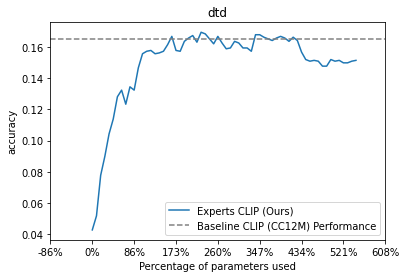

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 844/844 [00:18<00:00, 44.61it/s]


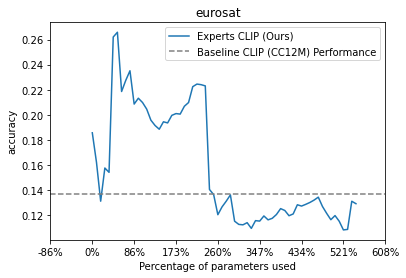

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:30<00:00,  8.18it/s]


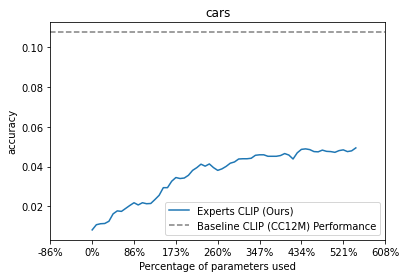

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3157/3157 [03:30<00:00, 14.96it/s]


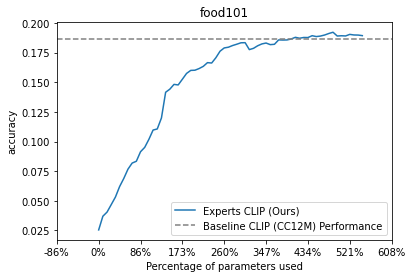

Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:43<00:00,  3.03it/s]


Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:06<00:00, 51.80it/s]


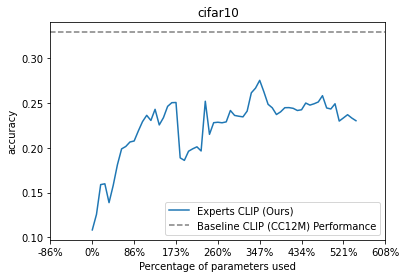

Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [01:43<00:00,  3.03it/s]


Files already downloaded and verified


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:05<00:00, 56.76it/s]


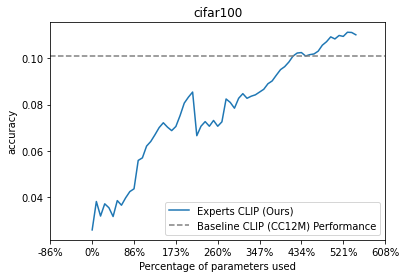

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:12<00:00, 14.31it/s]


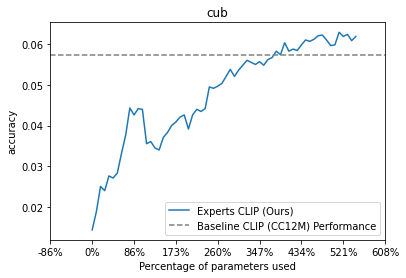

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [00:08<00:00, 46.17it/s]


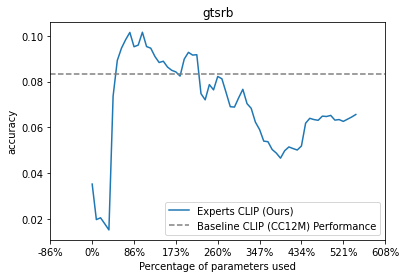

NOTE PROPER METRIC IS MEAN PER CLASS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [01:04<00:00,  3.01it/s]


NOTE PROPER METRIC IS MEAN PER CLASS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:15<00:00, 12.82it/s]


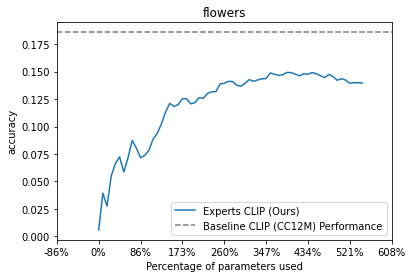

NOTE PROPER METRIC IS MEAN PER CLASS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:35<00:00,  2.94it/s]


NOTE PROPER METRIC IS MEAN PER CLASS


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [00:20<00:00,  5.16it/s]


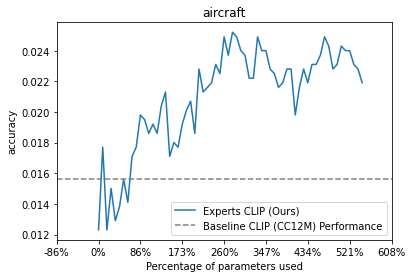

In [50]:
for ds in ds_names:
    if ds=='mnist': continue
    simple_ordered_plot(model, ds, preprocess, group_size=8, normalization='mask', baseline_model=cc_model,
                   parameter_x_axis=True)

In [ ]:
generate_order_variance_plot(model, 'mnist', grayscale_preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'eurosat', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'cars', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'food101', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'cifar10', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'cifar100', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'cub', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'gtsrb', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'flowers', preprocess, group_size=64, global_norm=False, baseline_model=cc_model)

In [ ]:
generate_order_variance_plot(model, 'aircraft', preprocess, group_size=8, global_norm=False, baseline_model=cc_model)

In [41]:
generate_order_variance_plot(cc_model, 'aircraft', preprocess)

NOTE PROPER METRIC IS MEAN PER CLASS


 48%|██████████████████████████████████████████████████████████▌                                                                | 50/105 [00:11<00:12,  4.24it/s]


KeyboardInterrupt: 

In [40]:
ds_names = ['dtd', 'mnist', 'eurosat', 'cars', 'food101', 'cifar10',
           'cifar100', 'cub', 'gtsrb', 'flowers', 'aircraft']

In [ ]:
for ds_name in ds_names:
    for net in [model, cc_model]:
        print(ds_name)
        print(test_on_dataset(net, ds_name,
                              grayscale_preprocess if ds_name=='mnist' else preprocess))

In [ ]:
for ds_name in ds_names:
    print(ds_name, len(dataset_constructor(ds_name, 'val', preprocess)))